In [20]:
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
import rdkit
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from src.data.datasets import *

In [ ]:
dataset = DiffSBDDSamples(docked=False)

prot, mol = dataset[0]

In [ ]:
def count_clashes(prot, lig, tollerance=0.5):
    clashes = 0

    n_lig_atoms = int(lig.GetNumAtoms())
    n_prot_atoms = int(prot.GetNumAtoms())

    pt = Chem.GetPeriodicTable()

    prot_pos = prot.GetConformer().GetPositions()
    lig_pos = lig.GetConformer().GetPositions()

    # Calculate the distance between all atoms in the protein and the ligand
    dists = np.sqrt(((prot_pos[:, None, :] - lig_pos[None, :, :]) ** 2).sum(axis=-1))

    for i in range(n_lig_atoms):
        for j in range(n_prot_atoms):
            dist = dists[j, i]

            lig_vdw = pt.GetRvdw(lig.GetAtomWithIdx(i).GetAtomicNum())
            prot_vdw = pt.GetRvdw(prot.GetAtomWithIdx(j).GetAtomicNum())

            if dist + tollerance < lig_vdw + prot_vdw:
                clashes += 1
    return clashes


[count_clashes(prot, mol[0]) for i in tqdm(range(100))]

In [12]:
count_clashes(prot, mol[0])

398

In [15]:
def count_clashes(prot, lig, tollerance=0.5):
    clashes = 0

    n_lig_atoms = int(lig.GetNumAtoms())
    n_prot_atoms = int(prot.GetNumAtoms())

    pt = Chem.GetPeriodicTable()

    prot_pos = prot.GetConformer().GetPositions()
    lig_pos = lig.GetConformer().GetPositions()

    # Calculate the distance between all atoms in the protein and the ligand
    dists = np.sqrt(((prot_pos[:, None, :] - lig_pos[None, :, :]) ** 2).sum(axis=-1))

    # make list of van der waals radii
    lig_vdw = [
        pt.GetRvdw(lig.GetAtomWithIdx(i).GetAtomicNum()) for i in range(n_lig_atoms)
    ]
    prot_vdw = [
        pt.GetRvdw(prot.GetAtomWithIdx(i).GetAtomicNum()) for i in range(n_prot_atoms)
    ]

    # make array of sums of van der waals radii
    vdw_sums = (np.array(lig_vdw)[:, None] + np.array(prot_vdw)[None, :]).T

    # clashes = np.sum(dists < vdw_sums + tollerance)

    # return clashes
    return dists, vdw_sums


# for data in tqdm(dataset):
#     prot, mols = data
#     for mol in mols:
#         count_clashes(prot, mol)

In [24]:
count_clashes(prot, mol[0])

87

In [17]:
dists_list = []
vdw_sums_list = []

for mol in mols:
    dists, vdw_sums = count_clashes(prot, mol)
    dists_list.append(dists)
    vdw_sums_list.append(vdw_sums)

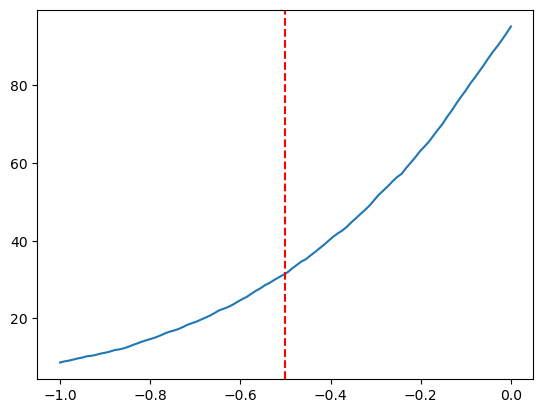

In [35]:
# Plot variation in number of clashes with threshold tollerance

tollerances = np.linspace(-1, 0, 100)

# baseline = [vdw_sums - dists for dists, vdw_sums in zip(dists_list, vdw_sums_list)]

value = []

for tollerance in tollerances:
    clashes = [
        np.sum(dists < vdw_sums + tollerance)
        for dists, vdw_sums in zip(dists_list, vdw_sums_list)
    ]
    value.append(np.mean(clashes))

plt.plot(tollerances, value)
# plot v line at -0.5 on x axis
plt.axvline(x=-0.5, color="r", linestyle="--")
# plt.xticks(np.arange(-1, 2, 0.2))